In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and Setting Up Utility Functions for Deep Learning

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
from torch.utils.data import random_split
import torchvision.utils as vutils
from PIL import Image
from torchvision.datasets import VisionDataset
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import csv
import shutil
from torch.optim import Optimizer
from torch.cuda.amp import autocast, GradScaler
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

# Extracting Images from Zip File in Google Drive

In [5]:
# Path to the mounted Google Drive folder
drive_path = '/content/drive/MyDrive'

# Path to the zip file within your Google Drive
zip_file_path = os.path.join(drive_path, '/content/drive/MyDrive/CAPSTONE-1-/images.zip')

# Path to the folder where you want to extract the images
extracted_folder_path = '/content/extracted_images1'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Dataset Preparation and Data Loading for Image Classification

In [6]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001
image_folder = '/content/extracted_images1/images'
csv_file = 'image_categories.csv'
# Open the CSV file for writing
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Category'])

    # Iterate over the files in the image folder
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            # Extract the category from the image name
            category = filename.split('-')[1].lower()

            # Write the image name and category to a new row in the CSV file
            writer.writerow([filename, category])

print("Image names and categories have been written to image_categories.csv.")

# Create subfolders based on categories
subfolder_path = '/content/extracted_images1/categories'
os.makedirs(subfolder_path, exist_ok=True)

# Open the CSV file for reading
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row

    # Iterate over the rows in the CSV file
    for row in reader:
        image_name = row[0]
        category = row[1]

        # Create the subfolder if it doesn't exist
        category_path = os.path.join(subfolder_path, category)
        os.makedirs(category_path, exist_ok=True)

        # Move the image to the corresponding subfolder
        source_path = os.path.join(image_folder, image_name)
        destination_path = os.path.join(category_path, image_name)
        shutil.move(source_path, destination_path)

print("Images have been categorized and moved to subfolders.")


# Set the root directory of your dataset
data_root = "/content/extracted_images1/categories"

# Define the transformations to apply to your data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB images
])

# Load the dataset using ImageFolder
dataset = ImageFolder(root=data_root, transform=transform)

train_ratio = 0.8  # 80% for training
test_ratio = 1 - train_ratio  # Remaining 20% for testing

# Calculate the sizes of train and test sets based on the proportions
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Use random_split to split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Image names and categories have been written to image_categories.csv.
Images have been categorized and moved to subfolders.


# Classes Distribution

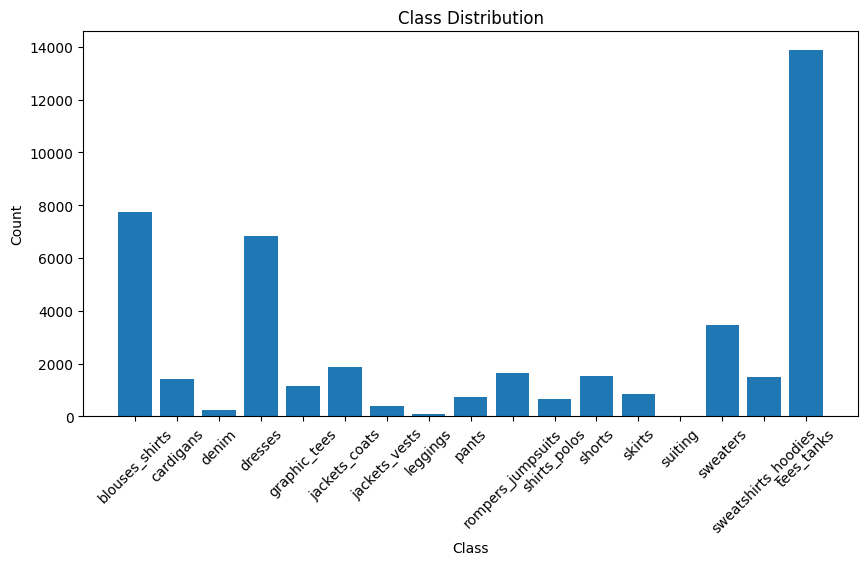

In [ ]:
class_names = dataset.classes
class_counts = [len(os.listdir(os.path.join(data_root, c))) for c in class_names]

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# verfying that the lables match the images

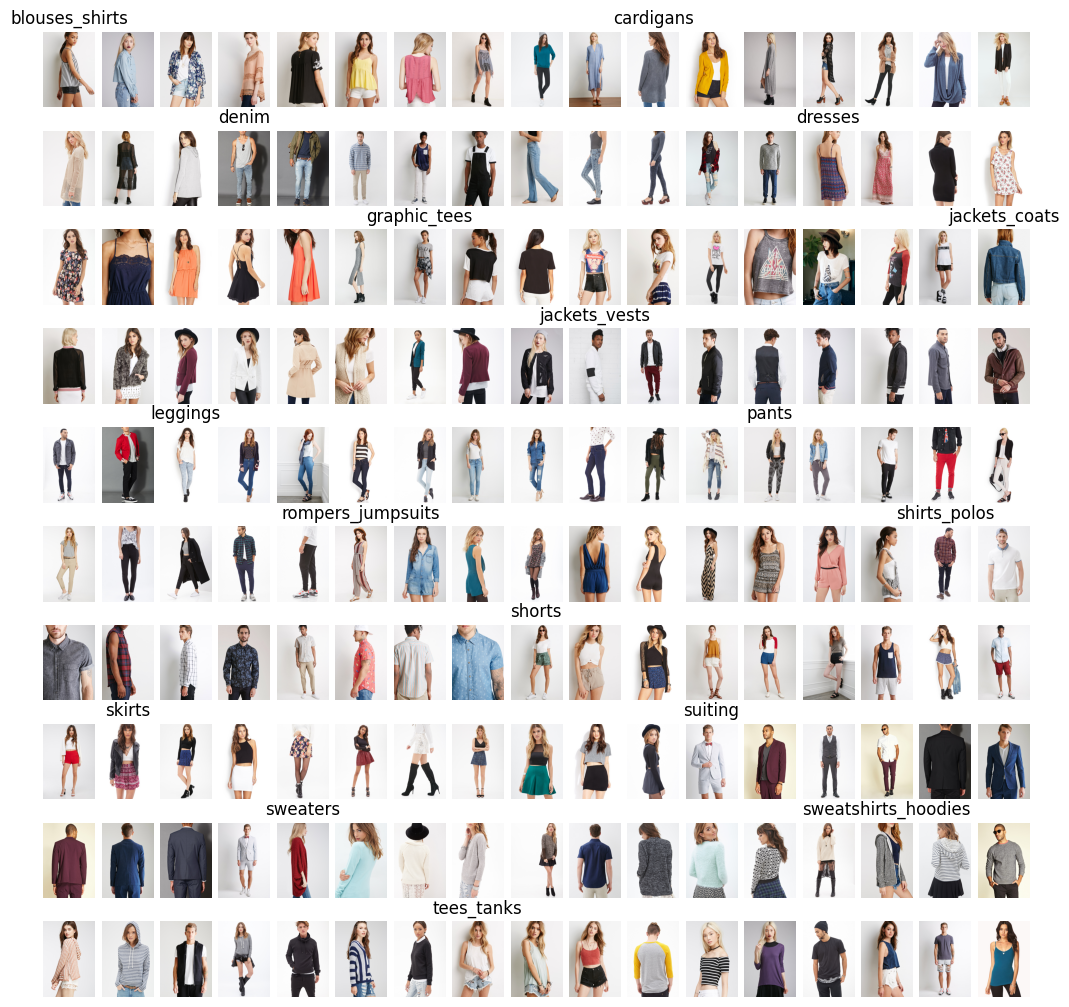

In [ ]:
num_samples_per_class = 10
num_classes = len(class_names)
plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_root, class_name)
    image_files = os.listdir(class_path)[:num_samples_per_class]

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)

        plt.subplot(num_samples_per_class, num_classes, i * num_samples_per_class + j + 1)
        plt.imshow(image)
        plt.axis('off')

        if j == 0:
            plt.title(class_name)

plt.tight_layout(pad=0.5)
plt.show()

# Training a ResNet-50 Model for Image Classification

In [ ]:
# Define the ResNet-50 model
model = models.resnet50(pretrained=True)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
num_classes = 17
model.fc = nn.Linear(2048, num_classes)

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


scaler = GradScaler()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print batch loss and accuracy
        batch_loss = running_loss / (i + 1)
        batch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], '
              f'Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%')

    # Print epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

print('Finished Training')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch [1/10], Batch [528/552], Loss: 1.4522, Accuracy: 50.68%
Epoch [1/10], Batch [529/552], Loss: 1.4519, Accuracy: 50.70%
Epoch [1/10], Batch [530/552], Loss: 1.4518, Accuracy: 50.71%
Epoch [1/10], Batch [531/552], Loss: 1.4513, Accuracy: 50.71%
Epoch [1/10], Batch [532/552], Loss: 1.4511, Accuracy: 50.72%
Epoch [1/10], Batch [533/552], Loss: 1.4507, Accuracy: 50.74%
Epoch [1/10], Batch [534/552], Loss: 1.4506, Accuracy: 50.74%
Epoch [1/10], Batch [535/552], Loss: 1.4504, Accuracy: 50.76%
Epoch [1/10], Batch [536/552], Loss: 1.4505, Accuracy: 50.76%
Epoch [1/10], Batch [537/552], Loss: 1.4503, Accuracy: 50.76%
Epoch [1/10], Batch [538/552], Loss: 1.4501, Accuracy: 50.76%
Epoch [1/10], Batch [539/552], Loss: 1.4500, Accuracy: 50.76%
Epoch [1/10], Batch [540/552], Loss: 1.4498, Accuracy: 50.77%
Epoch [1/10], Batch [541/552], Loss: 1.4491, Accuracy: 50.80%
Epoch [1/10], Batch [542/552], Loss: 1.4485, Accuracy: 50.82%
Epoch [1/10], Batch

# Saving Trained ResNet-50 Model

In [ ]:
torch.save(model.state_dict(), 'resnet_modelf.pth')

# Testing *the* Trained ResNet-50 Model for Image Classification

In [ ]:
model = resnet50(pretrained=False)
num_classes = 17
model.fc = nn.Linear(2048, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model
model.load_state_dict(torch.load('/content/drive/MyDrive/resnet_modelf.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect predicted labels and true labels
        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


# Metrics

Test Accuracy: 85.35%


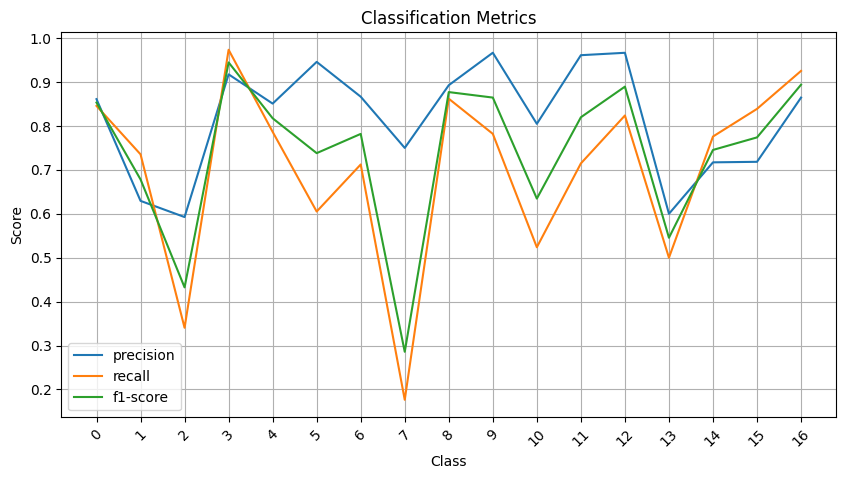

In [ ]:
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Calculate precision, recall, and F1 score
report = classification_report(all_labels, all_predicted, output_dict=True)

# Plot precision, recall, and F1 score
metrics = ['precision', 'recall', 'f1-score']
labels = [str(i) for i in range(num_classes)]  # Replace with your class labels

plt.figure(figsize=(10, 5))
for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in labels]
    plt.plot(labels, scores, label=metric)

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# confusion_matrix

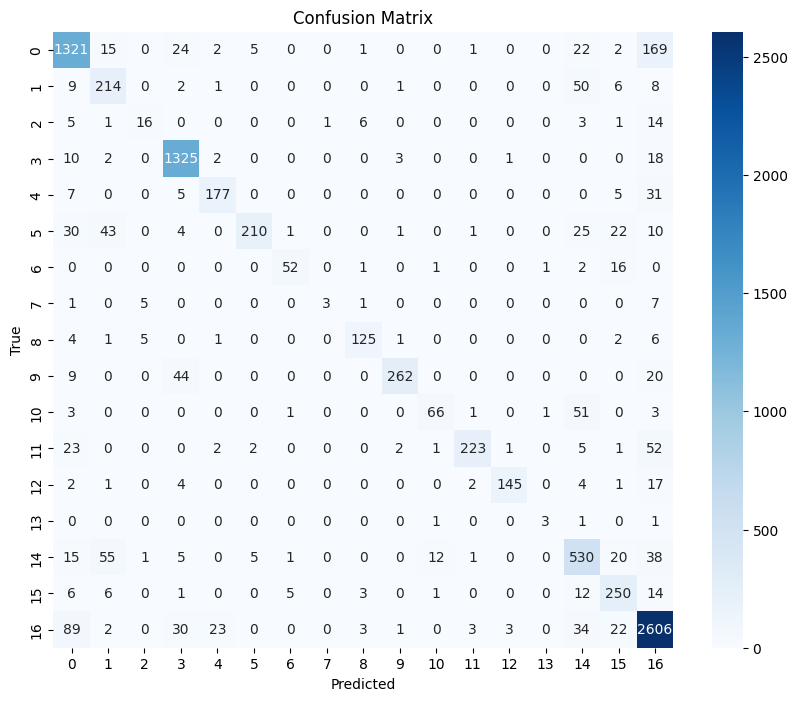

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predicted)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Function for Visualizing Example Data and Predictions

In [ ]:
def get_example_data(index, dataset, model, device, classes):
    # Retrieve the example data from the dataset
    image, label = dataset[index]
    imagea = image

    # Move data to the appropriate device
    image = image.to(device).unsqueeze(0)  # Add a batch dimension

    # Make predictions using the model
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # Convert the predicted label and actual label to their corresponding values
    predicted_value = classes[predicted.item()]
    actual_value = classes[label]

    # Plot the image
    grid = vutils.make_grid(imagea, normalize=True)
    # Convert the grid to a numpy array
    imagea = grid.permute(1, 2, 0).cpu().numpy()

    # Set figure size and create subplots
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)

    # Plot the image
    ax.imshow(imagea)
    ax.axis('off')

    # Add text overlay
    text = f'Actual: {actual_value}\nPredicted: {predicted_value}'
    ax.text(10, 10, text, color='white', backgroundcolor='black', fontsize=20,
            verticalalignment='top', horizontalalignment='left')

    plt.show()

# Visualizing Example Data and Predictions for a Test Image

Note: The number "199" can be changed to any index within the test dataset to visualize a different test image.

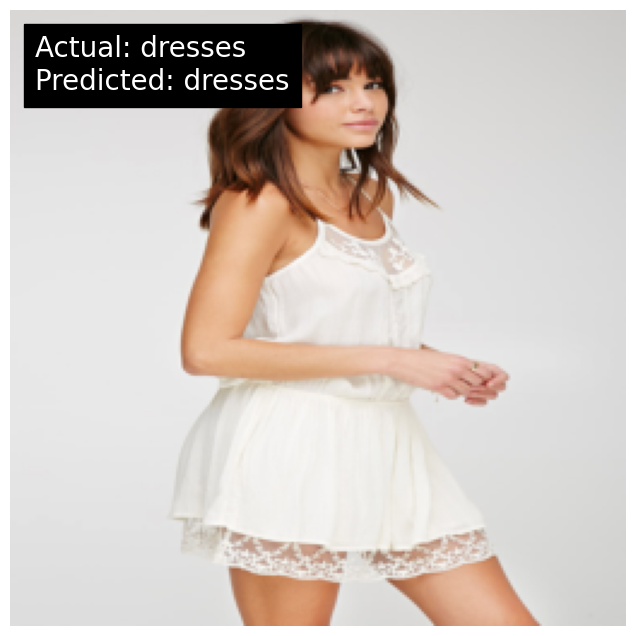

In [ ]:
classes = dataset.classes
get_example_data(199, test_dataset, model, device,classes)

# Loading back the model

In [ ]:
# Define the model architecture
model = models.resnet50(pretrained=False)
num_classes = 17
model.fc = nn.Linear(2048, num_classes)

# Specify the path to the saved model
model_path = '/content/drive/MyDrive/CAPSTONE-1-/resnet_modelf.pth'

# Load the saved model
device = torch.device('cpu')  # Set the device to CPU
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Function that predicts with a picture from the environment

In [23]:
def predict_and_plot_image(image_path, model, device, classes):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    imagea = image
    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to model's input size
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])
    image = preprocess(image)

    # Move data to the appropriate device
    image = image.to(device).unsqueeze(0)  # Add a batch dimension

    # Make predictions using the model
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # Convert the predicted label to its corresponding value
    predicted_value = classes[predicted.item()]

    # Plot the image
    plt.figure(figsize=(12, 12))
    plt.imshow(imagea)
    plt.axis('off')

    # Add prediction text overlay
    plt.text(10, 10, f'Predicted: {predicted_value}', color='white', backgroundcolor='black', fontsize=12,
             verticalalignment='top', horizontalalignment='left')

    plt.show()


# EX1

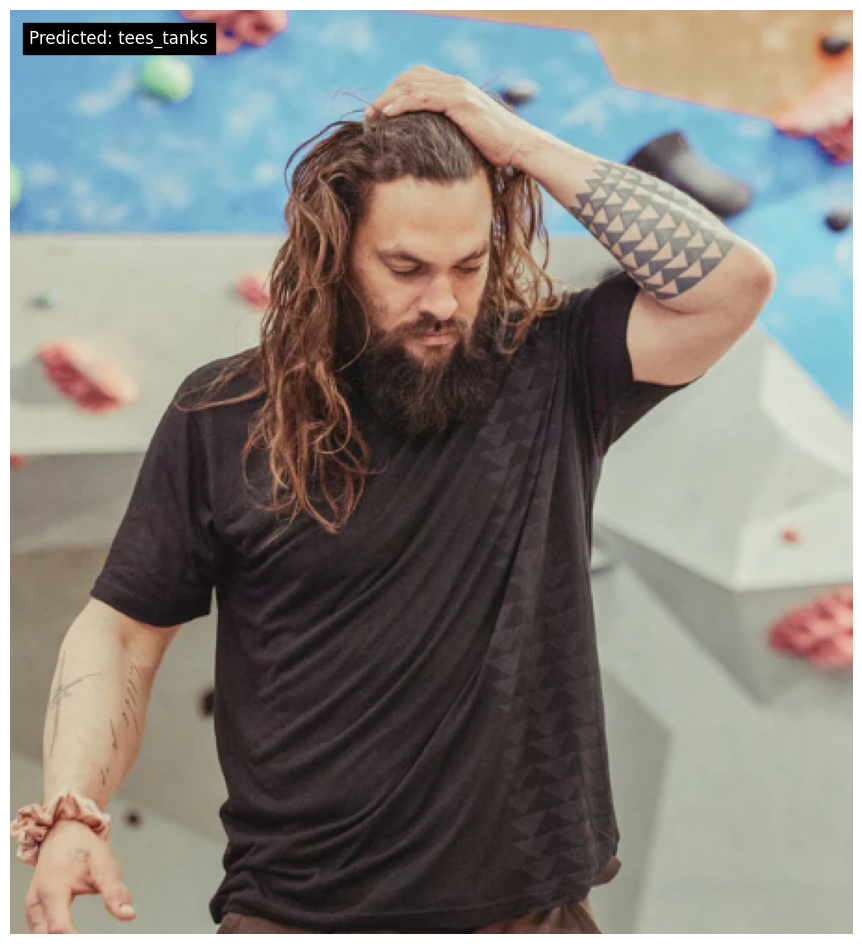

In [24]:
classes = dataset.classes
image_path = "/content/2023-07-04_112638.png"
predict_and_plot_image(image_path, model, device, classes)

# EX2

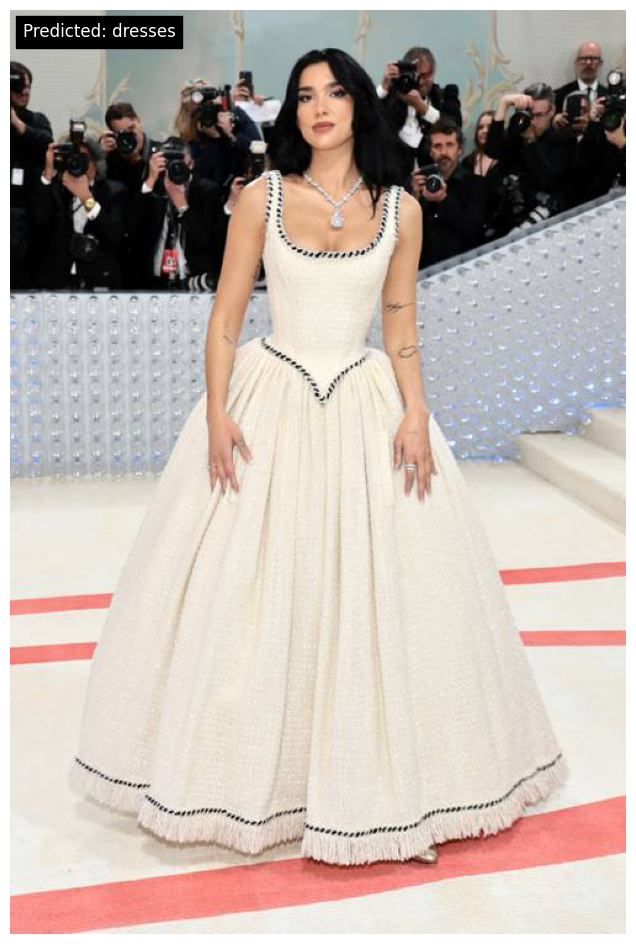

In [25]:
classes = dataset.classes
image_path = "/content/dil.jpg"
predict_and_plot_image(image_path, model, device, classes)